In [ ]:
#loading the OMG set for drive
from google.colab import drive
drive.mount('/content/drive')

!cp drive/MyDrive/Colab/OMG.zip OMG.zip
import shutil

shutil.rmtree("omg")

!mkdir omg

!unzip 'OMG.zip' -d omg

In [ ]:
#loading the OMG set from drive
from google.colab import drive
drive.mount('/content/drive')

!cp drive/MyDrive/Colab/Test_videos.zip Test_videos.zip
import shutil

#shutil.rmtree("videos")

!mkdir videos

!unzip 'Test_videos.zip' -d videos

In [1]:
#### READING AFF WILD INSTEAD
#loading the OMG set from drive
from google.colab import drive
drive.mount('/content/drive')

PATH_ANNOTATIONS = "drive/MyDrive/Colab/AFF_wild/Train_Set_annotations"
!cp drive/MyDrive/Colab/AFF_wild/Train_Set.zip Train_Set.zip
import shutil
!mkdir videos
#shutil.rmtree("videos")

!unzip 'Train_Set.zip' -d videos

Mounted at /content/drive
Archive:  Train_Set.zip
   creating: videos/Train_Set/
  inflating: videos/__MACOSX/._Train_Set  
  inflating: videos/Train_Set/236.mp4  
  inflating: videos/__MACOSX/Train_Set/._236.mp4  
  inflating: videos/Train_Set/94-30-1920x1080.mp4  
  inflating: videos/__MACOSX/Train_Set/._94-30-1920x1080.mp4  
  inflating: videos/Train_Set/116.avi  
  inflating: videos/__MACOSX/Train_Set/._116.avi  
  inflating: videos/Train_Set/418.mp4  
  inflating: videos/__MACOSX/Train_Set/._418.mp4  
  inflating: videos/Train_Set/430.mp4  
  inflating: videos/__MACOSX/Train_Set/._430.mp4  
  inflating: videos/Train_Set/424.mp4  
  inflating: videos/__MACOSX/Train_Set/._424.mp4  
  inflating: videos/Train_Set/395.mp4  
  inflating: videos/__MACOSX/Train_Set/._395.mp4  
  inflating: videos/Train_Set/394.mp4  
  inflating: videos/__MACOSX/Train_Set/._394.mp4  
  inflating: videos/Train_Set/57-25-426x240.mp4  
  inflating: videos/__MACOSX/Train_Set/._57-25-426x240.mp4  
  inflating: 

In [2]:
import os
def get_dirs(basePath):
  dirs = []
  for (dirpath, dirnames, filenames) in os.walk(basePath):
    dirs.extend(dirnames)
    break
  return dirs
def get_files(basePath):
  files = []
  for (dirpath, dirnames, filenames) in os.walk(basePath):
    files.extend(filenames)
    break
  return files
print('completed')

completed


In [3]:
import cv2 as cv
import tensorflow.keras.backend as K
import numpy as np
import pandas as pd
import os
import tensorflow as tf
import keras.backend as KB
from keras.preprocessing.image import ImageDataGenerator, load_img, NumpyArrayIterator
from keras.layers import Conv2D, Dense, BatchNormalization, Activation, Dropout, MaxPooling2D, Flatten
from keras.optimizers import Adam, RMSprop, SGD
from keras import regularizers
from keras.callbacks import ModelCheckpoint, CSVLogger, TensorBoard, EarlyStopping, ReduceLROnPlateau
import datetime
import matplotlib.pyplot as plt
from keras.utils import plot_model
import cv2 as cv
import keras


def ccc_loss(y_true, y_pred):
    return 1 - ((ccc_v(y_true, y_pred) + ccc_a(y_true, y_pred)) / 2)


def ccc_v(y_true, y_pred):
    """
    Concordance Correlation Coefficient for valence
    """
    x = y_true[:, 0]
    y = y_pred[:, 0]
    mx = K.mean(x, axis=0)
    my = K.mean(y, axis=0)
    xm, ym = x - mx, y - my
    rho = K.sum(xm * ym) / (K.sqrt(K.sum(xm ** 2)) * K.sqrt(K.sum(ym ** 2)))
    x_s = K.std(x)
    y_s = K.std(y)
    ccc = 2 * rho * x_s * y_s / (x_s ** 2 + y_s ** 2 + (mx - my) ** 2)
    return ccc


def ccc_a(y_true, y_pred):
    """
    Concordance Correlation Coefficient for arousal
    """
    x = y_true[:, 1]
    y = y_pred[:, 1]
    mx = K.mean(x, axis=0)
    my = K.mean(y, axis=0)
    xm, ym = x - mx, y - my
    rho = K.sum(xm * ym) / (K.sqrt(K.sum(xm ** 2)) * K.sqrt(K.sum(ym ** 2)))
    x_s = K.std(x)
    y_s = K.std(y)
    ccc = 2 * rho * x_s * y_s / (x_s ** 2 + y_s ** 2 + (mx - my) ** 2)
    return ccc


IMG_SIZE = 224
IMG_DIM =3

def extract_face(frame ):
    # extracting face and body and outputs tensor # add size of output image
    gray = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
    face_cascade = cv.CascadeClassifier(cv.data.haarcascades + 'haarcascade_frontalface_default.xml')
    faces = face_cascade.detectMultiScale(gray, 1.3, 4)
    # extract ROIS
    if type(faces) is tuple:
        return False
    for (x, y, w, h) in faces:
        # cv2.rectangle(frame,(x,y),(x+w,y+h),(255,0,0),2)
        ##simple scalings...
        #Check if frame is too small.
        if h < 50:
          return False
        temp = y - int(h / 3)
        if y - int(h / 3) < 0:
            temp = 0
        roi = frame[y:y + h, x:x +w]
    dim = (IMG_SIZE,IMG_SIZE)
    resized = cv.resize(roi, dim, interpolation=cv.INTER_AREA)/255
    # print(resized.shape)
    return resized
  
PATH="/content/drive/MyDrive/Colab/AffectNet/"
#model.load_weights(PATH+'VGG13_64.h5')
print("completed")
from keras.applications import vgg16
model_base = vgg16.VGG16(weights=None,include_top=False, input_shape=(224, 224, 3))

### CCC implementations
def add_top_layer(model_base,output_classes):
  bottom_model = model_base.output
  """creates the top or head of the model that will be
  placed ontop of the bottom layers"""
  #This first line here is only for the SENet.
  #bottom_model = model_base.get_layer('avg_pool').output
  #For vgg16
  #out = vgg_model.get_layer(layer_name).output
  #vgg_model_new = Model(vgg_model.input, out)
  #bottom_model = model_base.get_layer('avg_pool').output
  bottom_model = Flatten(name="flatten")(bottom_model)
  bottom_model = Dense(1024,activation='relu')(bottom_model)
  bottom_model = Dropout(0.50)(bottom_model)
  bottom_model = Dense(1024,activation='relu')(bottom_model)
  bottom_model = Dropout(0.50)(bottom_model)
  bottom_model = Dense(output_classes,activation='sigmoid')(bottom_model)
  return bottom_model
from keras.models import Model
model_head=add_top_layer(model_base,2)
#Connecting the two models
model=Model(inputs=model_base.input,outputs=model_head)
model.load_weights("drive/MyDrive/Colab/AffectNet/VGG16_noPretrain_224_2.h5")

#Removing the top layer here.
model = tf.keras.models.Sequential(model.layers[:-5])
print(model.summary())

completed
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 25

In [4]:
#### EXTRACT FEATURES INITIALLY
import os
import numpy as np
import pandas as pd
import csv
import cv2

def file_len(fname):
  for i, l in enumerate(f):
      pass
  return i + 1

PATH_ANNOTATIONS = "drive/MyDrive/Colab/AFF_wild/Train_Set_annotations"
files=get_files(PATH_ANNOTATIONS)
VIDS_PATH="videos/Train_Set"

#BASE_PATH="omg/OMG/Validation_videos"
#data=pd.read_csv('/content/drive/MyDrive/Colab/omg_TestVideos_WithLabels.csv')

FEATURES_PATH='drive/MyDrive/Colab/RNN_features'
#if os.path.exists(FEATURES_PATH) is False:
#  print('in')
#  !mkdir '$FEATURES_PATH'

files.sort()
print(files)
j=0
for file in files:
  if j<50:
    print(j,"  ",file)
    f = open(os.path.join(PATH_ANNOTATIONS,file), "r")
    file_name = file[:-4]
    #vid = row["utterance"]
    #vid_folder = row["video"]
    print(file_len(f))
    #annotation=np.asarray((valence,arousal))
    #Creating folder for each utterance.
    #FOLDER=os.path.join(FEATURES_PATH,file)
    #!mkdir "$FOLDER"
    #vid_to_read=os.path.join(os.path.join(BASE_PATH,vid_folder),vid)
    vid_to_read = os.path.join(VIDS_PATH,file_name+".mp4")
    if os.path.isfile(vid_to_read):
      print('true')
      cap = cv2.VideoCapture(vid_to_read)
    else:
      vid_to_read = os.path.join(VIDS_PATH,file_name+".avi")
      cap = cv2.VideoCapture(vid_to_read)
    sequence = []
    NOT_IN = False
    while True:
      succes=cap.grab()
      ret,frame=cap.retrieve(succes)
      if ret != True:
        break
      NOT_IN = True
      face=extract_face(frame)
      #if no frame is found just use the frame
      
      if type(face) is bool:
        #print('in')
        face = cv2.resize(frame, (IMG_SIZE,IMG_SIZE), interpolation=cv2.INTER_AREA)/255
      features=model.predict(face[None,...])
      sequence.append(features)
    if NOT_IN:
      save_path = os.path.join(FEATURES_PATH,file_name + '-features.npy')
      #print(save_path)
      print(np.asarray(sequence).shape)
      np.save(save_path,sequence)
    #print(sequence)
    j +=1
  else:
    break
  #temp_pred.append(pred[0])
  #temp_true.append(annotation)
path_file_save=FEATURES_PATH+".zip"
!zip -r '$path_file_save' i '$FEATURES_PATH'

!cp '$path_file_save' drive/MyDrive/Colab/extracted_features.zip 

['10-60-1280x720.txt', '10-60-1280x720_right.txt', '100-29-1080x1920.txt', '101-30-1080x1920.txt', '104-17-720x480.txt', '105.txt', '106-30-720x1280.txt', '106.txt', '107.txt', '108.txt', '110-30-270x480.txt', '110.txt', '111-25-1920x1080.txt', '111.txt', '112.txt', '113.txt', '114.txt', '116-30-1280x720.txt', '116.txt', '117-25-1920x1080.txt', '117.txt', '118.txt', '119-30-848x480.txt', '120-30-1280x720.txt', '120.txt', '121-24-1920x1080.txt', '121.txt', '122-60-1920x1080-1.txt', '122-60-1920x1080-2.txt', '122-60-1920x1080-3.txt', '122-60-1920x1080-4.txt', '122-60-1920x1080-5.txt', '122.txt', '123-25-1920x1080.txt', '123.txt', '124-30-720x1280.txt', '125-25-1280x720.txt', '125.txt', '126.txt', '127.txt', '128.txt', '129-24-1280x720.txt', '129.txt', '131-30-1920x1080.txt', '131.txt', '132.txt', '133.txt', '134.txt', '135-24-1920x1080_left.txt', '135-24-1920x1080_right.txt', '135.txt', '136-30-1920x1080.txt', '136.txt', '137.txt', '138-30-1280x720.txt', '138.txt', '139-14-720x480.txt', 

KeyboardInterrupt: ignored

In [ ]:
import numpy as np
import os
import tensorflow as tf
import numpy as np
from keras.preprocessing.image import ImageDataGenerator, load_img, NumpyArrayIterator
from keras.layers import Conv2D, Dense, BatchNormalization, Activation, Dropout, MaxPooling2D, Flatten
from keras.optimizers import Adam, RMSprop, SGD
from keras import regularizers
from keras.callbacks import ModelCheckpoint, CSVLogger, TensorBoard, EarlyStopping, ReduceLROnPlateau
import keras
from keras.models import Model
from google.colab import drive


#config = ConfigProto()
#config.gpu_options.allow_growth = True
#session = InteractiveSession(config=config)

In [ ]:
train=ImageDataGenerator(rescale=1./255., 
                         zoom_range=0.2,
                        horizontal_flip=True,
                         validation_split=0.2,)
train_generator=train.flow_from_dataframe(dataframe=dfTrain,
                                            directory="affectnet/train/train_set/images",
                                            x_col="path",
                                            y_col=["val", "aro"],
                                            subset="training",
                                            batch_size=64,
                                            seed=42,
                                            shuffle=True,
                                            class_mode="raw",
                                            target_size=(224,224))

validation_generator=train.flow_from_dataframe(dataframe=dfTrain,
                                            directory="affectnet/train/train_set/images",
                                            x_col="path",
                                            y_col=["val", "aro"],
                                            subset="validation",
                                            batch_size=64,
                                            seed=42,
                                            shuffle=True,
                                            class_mode="raw",
                                            target_size=(224,224))

test=ImageDataGenerator(rescale=1./255.)
test_generator=test.flow_from_dataframe(dataframe=dfVal,
                                            directory="affectnet/validation/val_set/images",
                                            x_col="path",
                                            y_col=["val", "aro"],
                                            subset=None,
                                            batch_size=64,
                                            seed=42,
                                            shuffle=True,
                                            class_mode="raw",
                                            target_size=(224,224))

Found 123278 validated image filenames.
Found 30819 validated image filenames.
Found 3999 validated image filenames.


In [ ]:
#COMMON setup
## Imports

### CCC implementations
def add_top_layer(model_base,output_classes):
  #bottom_model = model_base.output
  """creates the top or head of the model that will be
  placed ontop of the bottom layers"""
  #This first line here is only for the SENet.
  #bottom_model = model_base.get_layer('avg_pool').output
  #For vgg16
  #out = vgg_model.get_layer(layer_name).output
  #vgg_model_new = Model(vgg_model.input, out)
  bottom_model = model_base.get_layer('avg_pool').output
  bottom_model = Flatten(name="flatten")(bottom_model)
  bottom_model = Dense(1024,activation='relu')(bottom_model)
  bottom_model = Dropout(0.50)(bottom_model)
  bottom_model = Dense(1024,activation='relu')(bottom_model)
  bottom_model = Dropout(0.50)(bottom_model)
  bottom_model = Dense(output_classes,activation='sigmoid')(bottom_model)
  return bottom_model


import tensorflow.keras.backend as K

def ccc_loss(y_true, y_pred):
    return 1 - ((ccc_v(y_true, y_pred) + ccc_a(y_true, y_pred)) / 2)


def ccc_v(y_true, y_pred):
    """
    Concordance Correlation Coefficient for valence
    """
    x = y_true[:, 0]
    y = y_pred[:, 0]
    mx = K.mean(x, axis=0)
    my = K.mean(y, axis=0)
    xm, ym = x - mx, y - my
    rho = K.sum(xm * ym) / (K.sqrt(K.sum(xm ** 2)) * K.sqrt(K.sum(ym ** 2)))
    x_s = K.std(x)
    y_s = K.std(y)
    ccc = 2 * rho * x_s * y_s / (x_s ** 2 + y_s ** 2 + (mx - my) ** 2)
    return ccc


def ccc_a(y_true, y_pred):
    """
    Concordance Correlation Coefficient for arousal
    """
    x = y_true[:, 1]
    y = y_pred[:, 1]
    mx = K.mean(x, axis=0)
    my = K.mean(y, axis=0)
    xm, ym = x - mx, y - my
    rho = K.sum(xm * ym) / (K.sqrt(K.sum(xm ** 2)) * K.sqrt(K.sum(ym ** 2)))
    x_s = K.std(x)
    y_s = K.std(y)
    ccc = 2 * rho * x_s * y_s / (x_s ** 2 + y_s ** 2 + (mx - my) ** 2)
    return ccc

print('completed')

completed


Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/30
1926/1926 [==============================] - 1811s 939ms/step - loss: 0.7017 - ccc_v: 0.4380 - ccc_a: 0.1585 - val_loss: 0.4338 - val_ccc_v: 0.7139 - val_ccc_a: 0.4186

Epoch 00001: val_loss improved from inf to 0.43377, saving model to /content/drive/MyDrive/Colab/AffectNet/VGG16_full_224.h5
Epoch 2/30
1926/1926 [==============================] - 1925s 999ms/step - loss: 0.4237 - ccc_v: 0.7192 - ccc_a: 0.4338 - val_loss: 0.4015 - val_ccc_v: 0.7409 - val_ccc_a: 0.4561

Epoch 00002: val_loss improved from 0.43377 to 0.40150, saving model to /content/drive/MyDrive/Colab/AffectNet/VGG16_full_224.h5
Epoch 3/30
1926/1926 [==============================] - 1817s 943ms/step - loss: 0.3733 - ccc_v: 0.7515 - ccc_a: 0.5018 - val_loss: 0.3606 - val_ccc_v: 0.7614 - val_ccc_a: 0.5174

Epoch 00003: val_loss improved from 0.40150 to 0.36060, saving model to /content/drive/MyDrive/Colab/AffectNet/VGG16_full_224.h5
Epoch 4/30
1926/1926 [==============================] - 1805s 937ms/step - lo

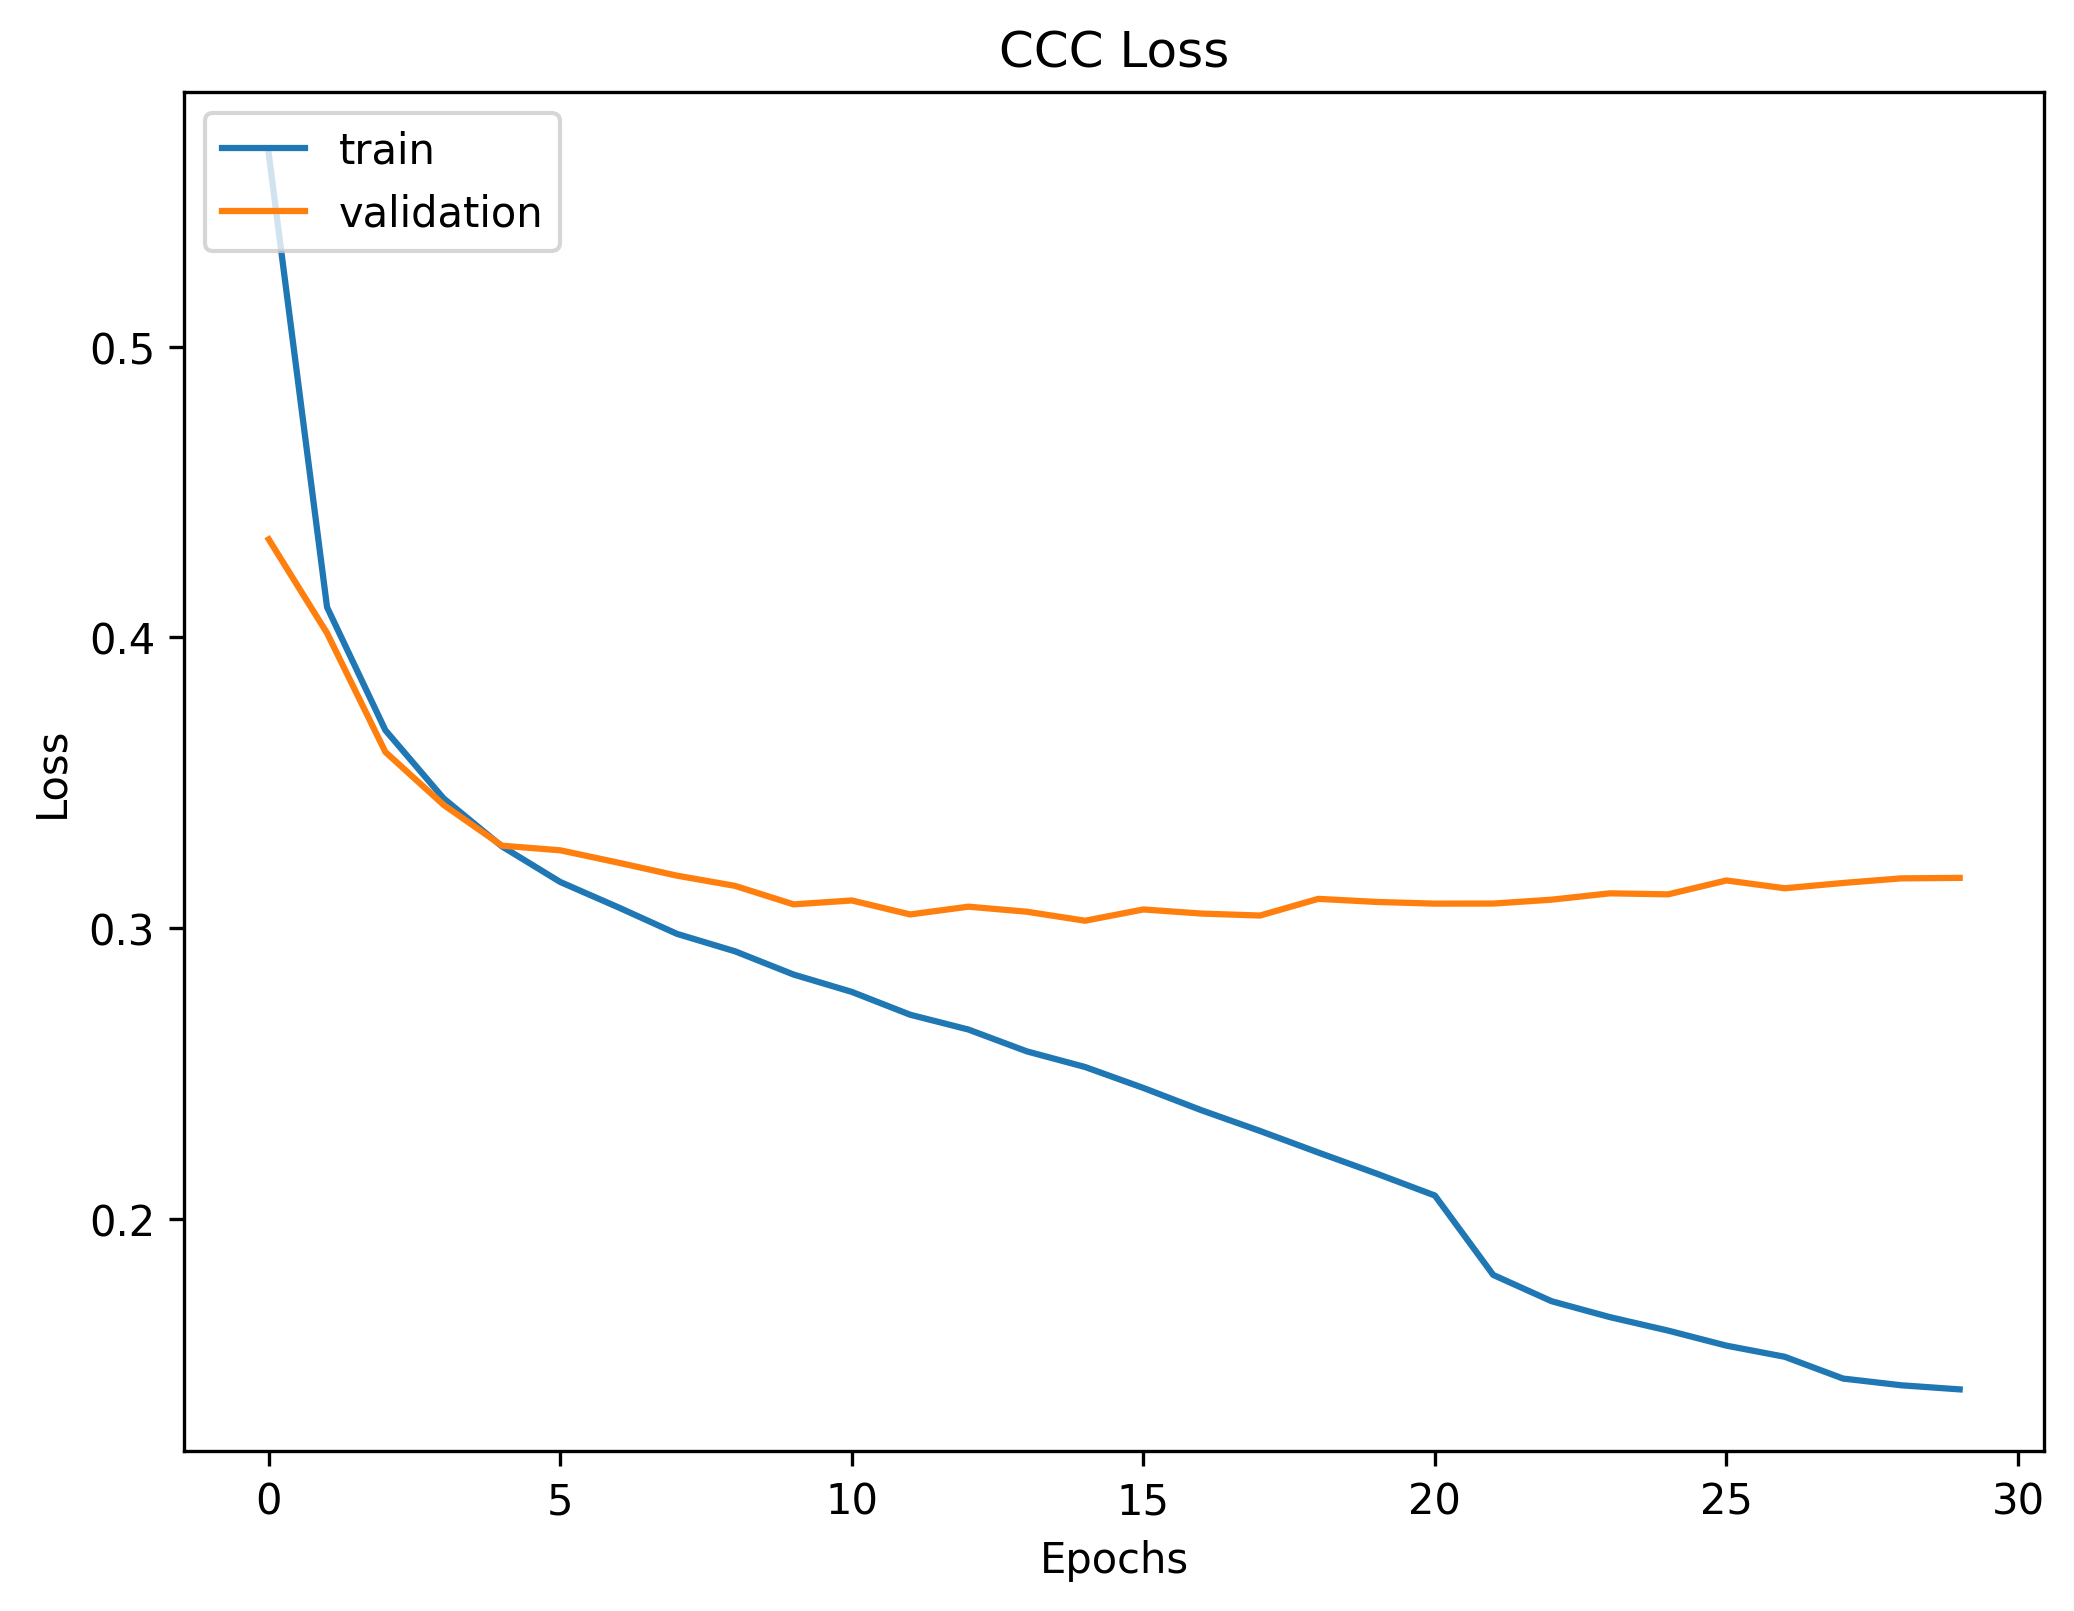

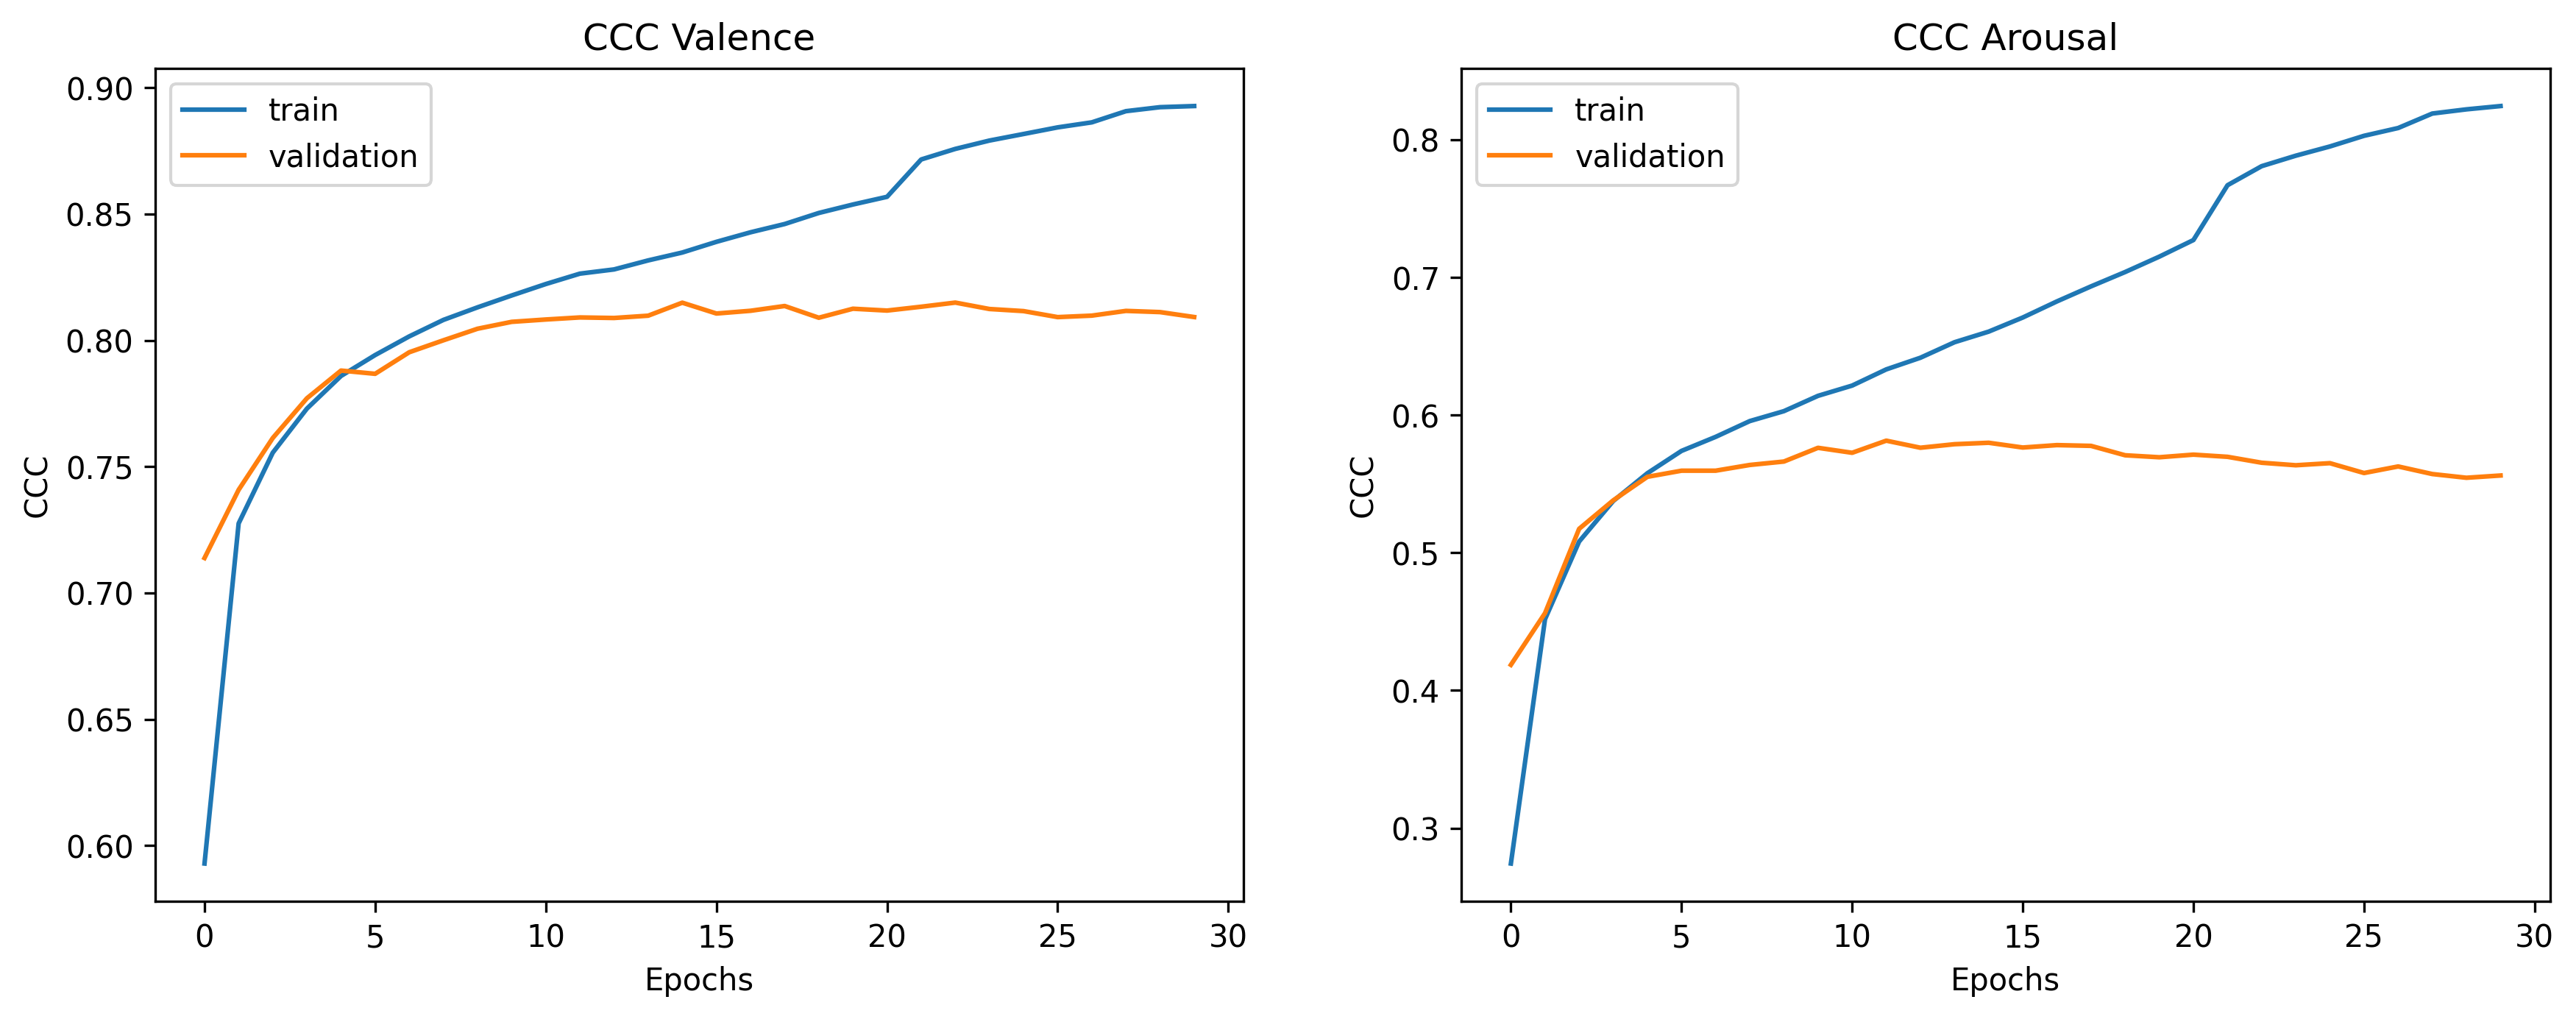

completed


In [ ]:
#from keras_vggface.vggface import VGGFace
from keras.applications import vgg16
import datetime
#custom parameters
nb_class = 2
hidden_dim=1024

model_base = vgg16.VGG16(weights=None,include_top=True, input_shape=(224, 224, 3),classes=2,
    classifier_activation='sigmoid')
for layers in model_base.layers:
  layers.trainable = True
#last_layer = model_base.get_layer('pool5').output
#x = Flatten(name='flatten')(last_layer)
#x = Dense(hidden_dim, activation='relu', name='fc6')(x)
#x = Dense(hidden_dim, activation='relu', name='fc7')(x)
#out = Dense(nb_class, activation='sigmoid', name='fc8')(x)
#model = Model(model_base.input, out)

NAME_OF_MODEL="VGG16_full_224"

#model=vgg16.VGG16(include_top=True, weights=None,    input_shape=(224,224,3),classes=2,
#    classifier_activation='sigmoid')
#Finalizing the model:
#from keras_vggface.vggface import VGGFace

#model_base = VGGFace(model='resnet50',include_top=False, input_shape=(224, 224, 3), pooling='avg') # pooling: None, avg or max

#print(model_base.summary())
print(model_base.summary())
model=model_base
## adding the regression layer on top
#model_head=add_top_layer(model_base,2)
#Connecting the two models
#model=Model(inputs=model_base.input,outputs=model_head)



opt = Adam(lr=0.0001, decay=1e-6)
#Selecting loss and metrics
model.compile(optimizer=opt, loss=ccc_loss, metrics=[ccc_v, ccc_a])
#Printing model summary

PATH="/content/drive/MyDrive/Colab/AffectNet/"
chk_path = PATH+NAME_OF_MODEL+'.h5'
log_dir = PATH+"checkpoint/logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

checkpoint = ModelCheckpoint(filepath=chk_path,
                               save_best_only=True,
                               verbose=1,
                               mode='min',
                               monitor='val_loss')

earlystop = EarlyStopping(monitor='val_loss',
                            min_delta=0,
                            patience=3,
                            verbose=1,
                            restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                                factor=0.2,
                                patience=6,
                                verbose=1,
                                min_delta=0.0001)

steps_per_epoch = train_generator.n // train_generator.batch_size
validation_steps = validation_generator.n // validation_generator.batch_size

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
csv_logger = CSVLogger(PATH+'training'+NAME_OF_MODEL+'.log')

callback = [checkpoint, reduce_lr, csv_logger]
print(steps_per_epoch)
print(validation_steps)

with tf.device('/device:GPU:0'):
  epochs=30
  #### fit_generator is only to use it together with tensorflow 1.14 and VGGFace2 dataset.
  model_hist = model.fit_generator(generator=train_generator,
                  validation_data=validation_generator,
                  epochs=epochs,
                  callbacks=callback,
                  steps_per_epoch=steps_per_epoch,
                  validation_steps=validation_steps)



##Loading weigths 
PATH="/content/drive/MyDrive/Colab/AffectNet/"
# Load the previously saved weights
#model.load_weights(PATH+NAME_OF_MODEL+'.h5')

#Loading the Data_set
# Change data_src variable as per your drive
data_src = '/content/drive/MyDrive/Colab/AffectNet'

#Loading the data into the correct format:
test_faces = np.load(data_src+'/validation_images.npy')/255
test_labels = (np.load(data_src+'/validation_annotations.npy')+1)/2
#Only for grayscale.
#from sklearn.model_selection import train_test_split

#x_test, _, y_test, _ = train_test_split(test_faces, test_labels, test_size=0.001, shuffle= True)
#train_datagen = ImageDataGenerator(rescale=1./255)

#training_set=train_datagen.flow(x_test,y_test,batch_size=64)
print(test_labels)

#Executing tests
print("Evaluate on test data")

results = model.evaluate(x=test_faces, y=test_labels, batch_size=64)
print("test loss, test acc:", results)
###

#figures
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300
plt.figure(figsize=(8,6))
plt.plot(model_hist.history['loss'])
plt.plot(model_hist.history['val_loss'])
plt.title('CCC Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

###Results for the model
### PLOTTING OF CCC SCORE
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)

plt.plot(model_hist.history['ccc_v'])
plt.plot(model_hist.history['val_ccc_v'])
plt.title('CCC Valence')
plt.xlabel('Epochs')
plt.ylabel('CCC')
plt.legend(['train', 'validation'], loc='upper left')

plt.subplot(1,2,2)
plt.plot(model_hist.history['ccc_a'])
plt.plot(model_hist.history['val_ccc_a'])
plt.title('CCC Arousal')
plt.xlabel('Epochs')
plt.ylabel('CCC')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

print('completed')